<a href="https://colab.research.google.com/github/Pyeonseohee/Deeplearning/blob/main/Deepnoid_Lecture02_FCN_test_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!git clone https://github.com/Pulsar-kkaturi/Deepnoid-Education.git

fatal: destination path 'Deepnoid-Education' already exists and is not an empty directory.


# 모듈 불러오기

In [15]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import keras.backend as K
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

# 경로 설정하기

In [16]:
BASE_PATH = r'./Deepnoid-Education/dataset/lung_cancer'
IMG_DATA_PATH = os.path.join(BASE_PATH, '2d_images')
MASK_DATA_PATH = os.path.join(BASE_PATH, '2d_masks')

In [17]:
IMG_DATA_PATH

'./Deepnoid-Education/dataset/lung_cancer/2d_images'

# 하이퍼 파라미터

하이퍼 파라미터를 이용해 인공지능 모델을 조정합니다. 주로 사용하는 하이퍼 파라미터는 다음과 같습니다.

In [18]:
IMG_HEIGHT, IMG_WIDTH = (96, 96) # 이미지 사이즈
EPOCHS = 10                      # 훈련 횟수
BATCH_SIZE = 5                   # 한번에 입력할 데이터 개수 
INIT_FILTERS = 32                # 모델 채널 크기
LEARNING_RATE = 2e-4             # 학습률
DECAY_RATE = 0.9                 # 학습률 감소 비율 
ACTIVATION_FN = 'elu'            # 활성함수 ex: relu, elu, sigmoid
DROP_RATE = 0.25                 # 드롭아웃 비율
VAL_RATIO = 0.2                  # 검증 데이터 비율

# 데이터 불러오기

이미지와 레이블 데이터를 불러옵니다.

glob.glob 함수를 이용해 경로에 있는 파일들을 검색할 수 있습니다.

In [19]:
img_path = sorted(glob.glob(os.path.join(IMG_DATA_PATH, '*.tif')))
mask_path = sorted(glob.glob(os.path.join(MASK_DATA_PATH, '*.tif')))

In [20]:
img_path

['./Deepnoid-Education/dataset/lung_cancer/2d_images/ID_0000_Z_0142.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_images/ID_0001_Z_0146.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_images/ID_0002_Z_0162.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_images/ID_0003_Z_0132.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_images/ID_0004_Z_0066.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_images/ID_0005_Z_0066.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_images/ID_0006_Z_0206.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_images/ID_0007_Z_0211.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_images/ID_0008_Z_0065.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_images/ID_0009_Z_0114.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_images/ID_0010_Z_0259.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_images/ID_0011_Z_0156.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_images/ID_0012_Z_0167.tif',
 './Deepnoid-Education/dataset/lung_ca

In [21]:
mask_path

['./Deepnoid-Education/dataset/lung_cancer/2d_masks/ID_0000_Z_0142.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_masks/ID_0001_Z_0146.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_masks/ID_0002_Z_0162.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_masks/ID_0003_Z_0132.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_masks/ID_0004_Z_0066.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_masks/ID_0005_Z_0066.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_masks/ID_0006_Z_0206.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_masks/ID_0007_Z_0211.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_masks/ID_0008_Z_0065.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_masks/ID_0009_Z_0114.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_masks/ID_0010_Z_0259.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_masks/ID_0011_Z_0156.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_masks/ID_0012_Z_0167.tif',
 './Deepnoid-Education/dataset/lung_cancer/2d_masks

모아놓은 파일들을 다음 함수를 이용해 불러옵니다.

In [22]:
def load_and_resize_png1(path, img_height, img_width):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, dsize=(img_height, img_width), interpolation=cv2.INTER_AREA)
    return img

def load_and_resize_png2(path, img_height, img_width):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32) / 255.
    img = cv2.resize(img, dsize=(img_height, img_width), interpolation=cv2.INTER_NEAREST)
    return img

def load_and_resize_nii(path, img_height, img_width):
    img = nb.load(path).get_data()
    img = np.transpose(np.squeeze(img), (1, 0))
    img = cv2.resize(img, dsize=(img_height, img_width), interpolation=cv2.INTER_AREA).astype(np.uint8)
    return img

불러온 이미지의 형태는 다음과 같이 (50, 96, 96)입니다. 

50장의 세로 96, 가로 96의 이미지를 불러왔다는 의미입니다.

In [23]:
imgs = np.stack([load_and_resize_png1(i_path, IMG_HEIGHT, IMG_WIDTH) for i_path in img_path])
print(imgs.shape)
masks = np.stack([load_and_resize_png2(m_path, IMG_HEIGHT, IMG_WIDTH) for m_path in mask_path])
print(masks.shape)

(50, 96, 96)
(50, 96, 96)


이미지를 직접 확인해볼까요?

왼쪽 이미지는 우리가 AI 모델에 넣을 input image이고, 오른쪽 이미지는 AI 모델을 학습시킬 때 필요한 정답, 즉 레이블 이미지입니다.

레이블 이미지와 같이 우리는 폐 영역을 분리해내는 AI 모델을 만들어 보겠습니다.

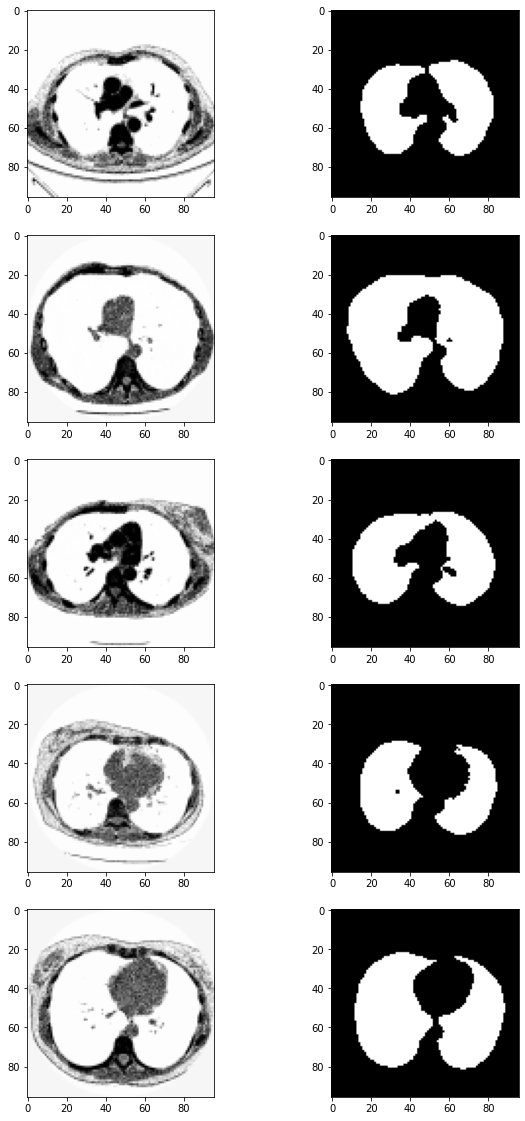

In [24]:
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    ax[i,0].imshow(imgs[i], cmap='gray')
    ax[i,1].imshow(masks[i], cmap='gray')
plt.show()

In [25]:
masks[4, 40:60, 0:20]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0.

# 데이터 전처리

AI 모델을 만들기 이전에 모델 학습에 도움을 줄 데이터 전처리를 살펴보겠습니다.

이 과정을 통해 AI모델이 받아들이기 쉬운 형태로 데이터를 가공하여 학습 성능을 올릴 수 있습니다.

먼저, 위에서 본 이미지 데이터를 컴퓨터가 실제로 인식하는 숫자 데이터로 확인해보겠습니다.

In [26]:
imgs[0]

array([[64716, 64733, 64725, ..., 64727, 64734, 64722],
       [64734, 64712, 64734, ..., 64726, 64714, 64729],
       [64725, 64724, 64716, ..., 64722, 64732, 64718],
       ...,
       [64714, 64721, 64726, ..., 64725, 64718, 64721],
       [64711, 64707, 64734, ..., 64741, 64721, 64722],
       [64715, 64730, 64726, ..., 64723, 64721, 64737]], dtype=uint16)

범위가 넓고 단위가 큰 숫자들을 정규화하여 학습 성능을 높여봅시다.

가장 기본적인 정규화 방법으로 고등학교 때 배운 Z-score를 사용할 수 있습니다.

In [27]:
n_imgs = len(imgs)
imgs = np.reshape(imgs, (n_imgs, -1))
imgs_t = np.transpose(imgs, (1,0))
imgs_t_norm = (imgs_t - np.mean(imgs_t, axis=0)) / np.std(imgs_t, axis=0)
imgs = np.transpose(imgs_t_norm, (1,0))
imgs = np.reshape(imgs, (n_imgs, IMG_HEIGHT, IMG_WIDTH))

다시 값을 확인해 봅시다.

In [28]:
imgs[0]

array([[0.59945889, 0.60033547, 0.59992296, ..., 0.60002609, 0.60038703,
        0.59976827],
       [0.60038703, 0.59925264, 0.60038703, ..., 0.59997452, 0.59935577,
        0.60012921],
       [0.59992296, 0.5998714 , 0.59945889, ..., 0.59976827, 0.6002839 ,
        0.59956202],
       ...,
       [0.59935577, 0.59971671, 0.59997452, ..., 0.59992296, 0.59956202,
        0.59971671],
       [0.59920108, 0.59899482, 0.60038703, ..., 0.60074797, 0.59971671,
        0.59976827],
       [0.59940733, 0.60018078, 0.59997452, ..., 0.59981983, 0.59971671,
        0.60054172]])

그 후 AI 모델에 넣을 수 있는 형태로 이미지 형태를 변형해 보겠습니다.

In [29]:
print('변경 전 형태: ', np.shape(imgs))
imgs = imgs[:,:,:,np.newaxis]
masks = masks[:,:,:,np.newaxis]
print('변경 후 형태: ', np.shape(imgs))

변경 전 형태:  (50, 96, 96)
변경 후 형태:  (50, 96, 96, 1)


마지막으로, 데이터를 학습용 데이터와 검증용 데이터로 나누어 봅시다.

학습용 데이터는 실제로 모델 학습에 사용되는 데이터이고,

검증용 데이터는 학습에 사용하지 않고 학습이 잘 이뤄지는지 성능 확인하는 용도로 사용합니다.

In [30]:
imgs_train, imgs_val, masks_train, masks_val = train_test_split(imgs, masks, test_size=VAL_RATIO)
print('훈련 데이터 개수: ', len(imgs_train))
print('검증 데이터 개수: ', len(imgs_val))

훈련 데이터 개수:  40
검증 데이터 개수:  10


# AI 모델을 구성하는 레이어 만들기

AI 모델은 여러 개의 레이어를 쌓아 올려 만듭니다.

가장 대표적인 레이어 구조인 CONV-BN-ACT-POOL 구조를 만들어 보겠습니다.

먼저 데이터가 들어가는 첫 번째 레이어를 만들어 봅시다.

In [31]:
layer1 = Input(shape=imgs_train.shape[1:])

그 다음으로 데이터의 특징을 추출할 Convolution 레이어를 연결하겠습니다.

In [32]:
layer2 = Conv2D(filters=8, kernel_size=(3, 3), activation=None, padding='same')(layer1)

다음으로 레이어 중간에서 정규화를 도와줄 Batch Normalization 레이어를 추가하겠습니다.

In [33]:
layer3 = BatchNormalization()(layer2)

Batch Normalization 이후 신호를 변환하여 다음 뉴런으로 전달하는 Activation function 레이어를 추가합니다.

In [34]:
layer4 = Activation('relu')(layer3) #### concat용

이미지 사이즈를 줄여주는 Pooling 레이어를 연결합니다.

In [35]:
layer5 = MaxPool2D(strides=(2, 2))(layer4)

다시 Conv-BN-ACT 레이어를 연결합니다.

In [36]:
layer6 = Conv2D(filters=16, kernel_size=(3, 3), activation=None, padding='same')(layer5)

In [37]:
layer7 = BatchNormalization()(layer6)

In [38]:
layer8 = Activation('relu')(layer7)

In [39]:
layer9 = MaxPool2D(strides=(2,2))(layer8)

In [40]:
layer10 = Conv2D(filters=32, kernel_size=(3, 3), activation=None, padding='same')(layer9)

In [44]:
layer11 = BatchNormalization()(layer10)

In [45]:
layer12 = Activation('relu')(layer11)

이번에는 이미지 사이즈를 키워주는 Upsampling 레이어를 연결합니다.

In [46]:
layer13 = UpSampling2D(size=(4, 4))(layer12)

마지막으로 output 레이어를 연결합니다.

In [47]:
layer14 = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(layer13)

지금까지 만든 레이어를 Model함수에 넣어 연결하면 모델이 완성됩니다.

In [48]:
model = Model(layer1, layer14)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 96, 96, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64    

# AI 모델 옵션 설정하기

AI 모델을 만든 후 여러가지 훈련 옵션을 설정할 수 있습니다. 

학습률(Learning_rate)과 손실함수(Loss function), 정확도 기준(Dice_score) 등을 설정해 봅시다.

먼저 정확도 기준으로 Dice score를 살펴봅시다.

In [49]:
 def dice_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

옵션을 compile을 통해 설정할 수 있습니다.

모델의 값을 학습시키는 Optimizer는 Adam을 사용하고, 정답 레이블과 예측값 사이의 차이를 계산하는 손실 함수는 Cross entropy를 사용했습니다.

마지막으로 정확도 판단 기준으로는 위에서 만든 Dice score를 사용합니다.

In [50]:
model.compile(optimizer=Adam(LEARNING_RATE), loss='binary_crossentropy', metrics=[dice_score])

# AI 모델 훈련하기

이렇게 준비한 AI모델을 fit함수를 이용해 훈련시킬 수 있습니다.

In [51]:
history = model.fit(imgs_train, masks_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(imgs_val, masks_val),
                    shuffle=True)

Epoch 1/10
8/8 [==============================] - 8s 34ms/step - loss: 0.6414 - dice_score: 0.2877 - val_loss: 0.7022 - val_dice_score: 0.3532
Epoch 2/10
8/8 [==============================] - 0s 8ms/step - loss: 0.5804 - dice_score: 0.3273 - val_loss: 0.6880 - val_dice_score: 0.3572
Epoch 3/10
8/8 [==============================] - 0s 7ms/step - loss: 0.5309 - dice_score: 0.3527 - val_loss: 0.6747 - val_dice_score: 0.3624
Epoch 4/10
8/8 [==============================] - 0s 8ms/step - loss: 0.4967 - dice_score: 0.3883 - val_loss: 0.6614 - val_dice_score: 0.3685
Epoch 5/10
8/8 [==============================] - 0s 7ms/step - loss: 0.4658 - dice_score: 0.4110 - val_loss: 0.6499 - val_dice_score: 0.3752
Epoch 6/10
8/8 [==============================] - 0s 8ms/step - loss: 0.4401 - dice_score: 0.4266 - val_loss: 0.6390 - val_dice_score: 0.3827
Epoch 7/10
8/8 [==============================] - 0s 8ms/step - loss: 0.4198 - dice_score: 0.4415 - val_loss: 0.6274 - val_dice_score: 0.3905
Epoch

# 훈련 결과 확인하기

훈련 겨과를 한 눈에 확인할 수 있는 그래프를 만들어 보겠습니다.

먼저 그래프의 y축에 사용할 값들을 history 항목에서 추출해 봅시다.

In [52]:
dice_score = history.history['dice_score']
val_dice_score = history.history['val_dice_score']
loss = history.history['loss']
val_loss = history.history['val_loss']

다음으로 그래프의 x축 값으로 사용할 epoch를 뽑아 보겠습니다.

In [53]:
epochs = range(len(dice_score))

각 값들을 확인해 볼까요?

In [54]:
dice_score

[0.2924836277961731,
 0.3269021511077881,
 0.35901522636413574,
 0.3873336911201477,
 0.4098181128501892,
 0.4319450259208679,
 0.4503054618835449,
 0.4670262932777405,
 0.48167169094085693,
 0.4953364133834839]

In [55]:
val_dice_score

[0.3531605303287506,
 0.3572095036506653,
 0.3623943626880646,
 0.3684631586074829,
 0.3752422332763672,
 0.3827463984489441,
 0.39051133394241333,
 0.39948657155036926,
 0.4085645079612732,
 0.4186188876628876]

In [56]:
loss

[0.6271895170211792,
 0.5676736235618591,
 0.5223195552825928,
 0.4874555468559265,
 0.4617999196052551,
 0.43873801827430725,
 0.418950617313385,
 0.4017665386199951,
 0.3864157199859619,
 0.37313175201416016]

In [57]:
val_loss

[0.7022056579589844,
 0.6880013346672058,
 0.6746792197227478,
 0.6613561511039734,
 0.6499484777450562,
 0.6389846801757812,
 0.6274131536483765,
 0.6172922253608704,
 0.6075873374938965,
 0.5981962084770203]

In [58]:
list(epochs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

이 값들을 이용해 그래프를 만들어 보겠습니다.

먼저 정확도 그래프를 그려볼까요?

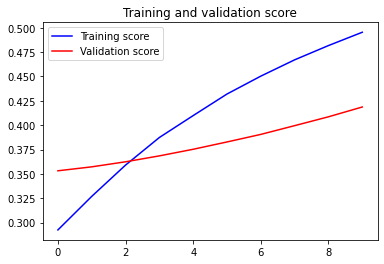

In [59]:
plt.plot(epochs, dice_score, 'b', color='blue', label='Training score')
plt.plot(epochs, val_dice_score, 'b', color='red', label='Validation score')
plt.title('Training and validation score')
plt.legend()
plt.show()

다음으로 손실 그래프를 살펴보겠습니다.

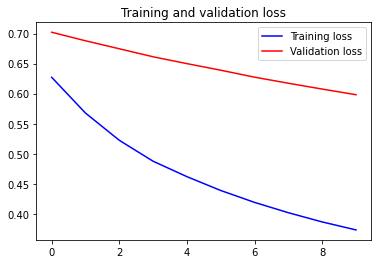

In [60]:
plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 이미지로 결과 확인하기

마지막으로 AI 모델이 실제로 폐 영역을 잘 분리하는지 이미지로 결과를 확인해 보겠습니다.

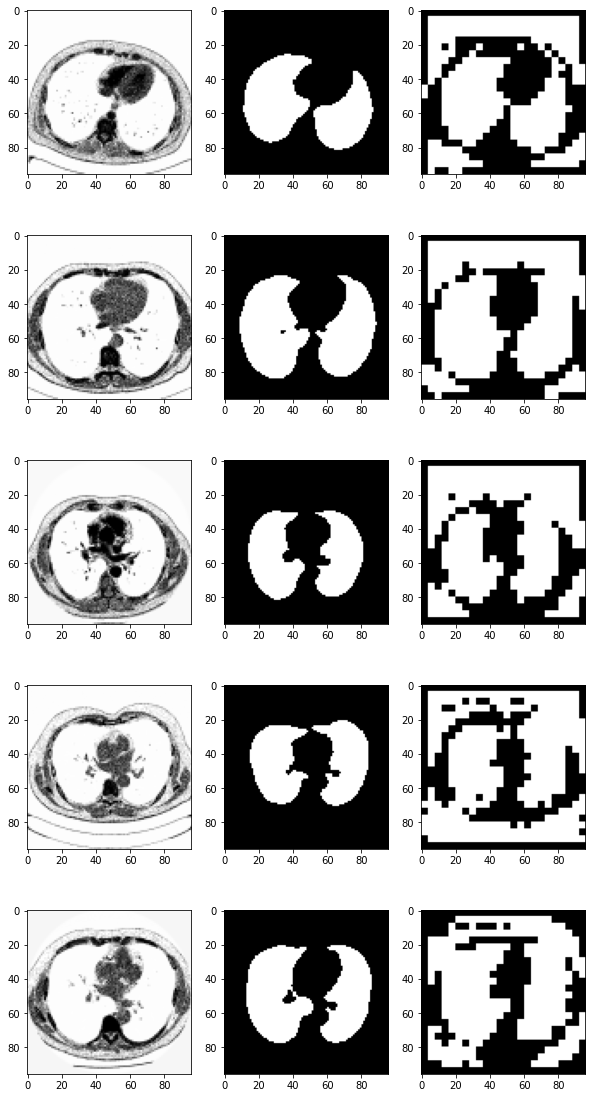

In [61]:
fix, ax = plt.subplots(5, 3, figsize=(10,20))
for i in range(5):
    pred = model.predict(imgs_train[i][np.newaxis, :, : ,:])
    mask = (pred >= 0.5).astype(np.uint8)
    ax[i, 0].imshow(imgs_train[i, :, :, 0], cmap='gray')
    ax[i, 1].imshow(masks_train[i, :, :, 0], cmap='gray')
    ax[i, 2].imshow(mask[0, :, :, 0], cmap='gray')
plt.show()